In [13]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, mean_squared_error
INF = np.inf

Read data 

In [2]:
mat = spio.loadmat('MUTAG.mat', squeeze_me=True)
type(mat)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
N = np.size(mutag)

Deal with one structure

In [99]:
#global variable: the counter for distinct labels of node 
Map = dict() 
ctr = 0 

tol = 0
#get total number of nodes in the dataset  
for i in range(N):
    graph = mutag[i]
    tol += len(graph[1].tolist()[0])

#tol will be used as the size of phi vector

28


### The WL Subtree Kernel
(all indices are 0-based)

In [134]:
#wl subtree kernel of two graphs  
def wl_substree_kernel (graph1, graph2, tol, H):  
    K = 0 

    #read graph structure 
    m1, l1 = graph1[0], graph1[1]
    m2, l2 = graph2[0], graph2[1]
    l1 = l1.tolist()[0]
    l2 = l2.tolist()[0]
    
    #---------------- Original Count -----------------------
    Map = dict(); #Key(string): true label; Value(int): label compression 
    ctr = 0 #label compression 
    
    #phi for original node labels counts 
    phi1 = np.zeros(tol)
    phi2 = np.zeros(tol) 
    
    #for graph1 
    labels1 = np.zeros(l1.shape[0])
    for i in range(l1.shape[0]): 
        str_label = str(l1[i])  #convert to string 
        if (str_label in Map): 
            labels1[i] = Map[str_label]
        else: 
            Map[str_label] = ctr 
            labels1[i] = ctr
            ctr += 1
        
    labels1 = np.int64(labels1)
    phi1[labels1] += 1
    
    
    #for graph2
    labels2 = np.zeros(l2.shape[0])
    for i in range(l2.shape[0]): 
        str_label = str(l2[i])  #convert to string 
        if (str_label in Map): 
            labels2[i] = Map[str_label]
        else: 
            Map[str_label] = ctr 
            labels2[i] = ctr
            ctr += 1
        
    labels2 = np.int64(labels2)
    phi2[labels2] += 1
    

    K += np.dot(phi1.T, phi2)
    
    #---------------- H iteration -----------------------
    new_labels1 = labels1
    new_labels2 = labels2
    
    for h in range(H):
        
        #Map = dict(); ctr = 0 
        
        #phi for h-th iteration
        phi1 = np.zeros(tol)
        phi2 = np.zeros(tol) 
        
        #for graph 1
        for i in range(l1.shape[0]): 
            #find the labels of neighbors
            neighbors_label = labels1[np.where(m1[i] == 1)]
            long_label = np.concatenate((np.array([labels1[i]]), neighbors_label))
            str_label = str(long_label)

            #check map 
            if (str_label in Map): 
                new_labels1[i] = Map[str_label]
            else: 
                Map[str_label] = ctr 
                new_labels1[i] = ctr
                ctr += 1

            phi1[np.int64(new_labels1)] += 1
            
        
        #for graph 2
        for i in range(l2.shape[0]): 
            #find the labels of neighbors
            neighbors_label = labels2[np.where(m2[i] == 1)]
            long_label = np.concatenate((np.array([labels2[i]]), neighbors_label))
            str_label = str(long_label)

            #check map 
            if (str_label in Map): 
                new_labels2[i] = Map[str_label]
            else: 
                Map[str_label] = ctr 
                new_labels2[i] = ctr
                ctr += 1

            phi2[np.int64(new_labels2)] += 1
            
            
        K += np.dot(phi1.T, phi2)
        
        labels1 = new_labels1
        labels2 = new_labels2
        labels1 = np.int64(labels1)
        labels2 = np.int64(labels2)
    
    return K 

## SVM

### Permute, split and evaluate performances of Kernel-based SVM

In [ ]:
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
print("X shape: ", mutag.shape)
print("Y shape: ", lmutag.shape)
N = y.shape[0]

"""
Compute accuracy of SVM 

Parameters:  
------------
K: precomputed Kernel matrix 
N: data set size 
c: penalty for SVC
"""
def get_accuracy (K, N, c): 

    #Paper: To exclude random effects of fold assignments, 
    #each repeat experiment 10 times  

    #Record the performance for each parameter trial on test set
    perf_all_val = []

    for t in range(10):  

        random_state = int(t)
        np.random.seed(random_state)
        idx_perm = np.random.permutation(N)

        #Permute the data 
        y_perm = y[idx_perm]
        K_perm = K[:, idx_perm]
        K_perm = K_perm[idx_perm, :]

        #The paper use 10-folder CV (training: 90%; test: 10%)
        num_train = int (N * (9/10))
        num_test = N - num_train 

        #Split the kernel matrix 
        K_train = K_perm[0:num_train, 0:num_train] 
        K_test = K_perm[num_train:N, 0:num_train]
        y_train = y_perm[0:num_train]
        y_test = y_perm[num_train:N]

        #Fit classifier on training data 
        clf = svm.SVC(kernel = 'precomputed', C = c)
        clf.fit(K_train, y_train)

        #predict on test  
        y_pred_test = clf.predict(K_test)

        #accuracy on test set  
        acc = accuracy_score(y_test, y_pred_test);
        perf_all_val.append(acc) 

        #print("The performance on the test set is: %3f" % acc)

    print("average performan: ", np.mean(perf_all_val), "\n")
    return np.mean(perf_all_val)



c_grid = np.array([0.001, 0.01, 0.1, 1, 10, 100])
h_grid = [x for x in list(range(11))]

perf = []
h_para = [] 
c_para = [] 
for h in h_grid: 
    for c in c_grid:  
        
        h_para.append(h)
        c_para.append(c)
        print("h: ", h, " c: ", c)
        
        #compute Kernel matrix K, given H  
        K = np.zeros([N, N])
        for i in range(N): 
            for j in range(N):
                if (i <= j ):
                    graph1 = X[i, ]
                    graph2 = X[j, ]
                    K[i, j] = wl_substree_kernel(graph1, graph2, tol, h)
                else: 
                    K[i, j] = K[j, i]
        
        acc = get_accuracy(K, N, c)
        perf.append(acc)
        h_para.append(h)
        c_para.append(c)

X shape:  (188,)
Y shape:  (188,)
h:  0  c:  0.001
average performan:  0.626315789474 

h:  0  c:  0.01
average performan:  0.626315789474 

h:  0  c:  0.1
average performan:  0.626315789474 

h:  0  c:  1.0
average performan:  0.647368421053 

h:  0  c:  10.0
average performan:  0.642105263158 

h:  0  c:  100.0
average performan:  0.642105263158 

h:  1  c:  0.001
average performan:  0.863157894737 

h:  1  c:  0.01
average performan:  0.852631578947 

h:  1  c:  0.1
average performan:  0.857894736842 

h:  1  c:  1.0
average performan:  0.857894736842 

h:  1  c:  10.0
average performan:  0.857894736842 

h:  1  c:  100.0
average performan:  0.857894736842 

h:  2  c:  0.001
average performan:  0.873684210526 

h:  2  c:  0.01
average performan:  0.873684210526 

h:  2  c:  0.1
average performan:  0.873684210526 

h:  2  c:  1.0
average performan:  0.873684210526 

h:  2  c:  10.0
average performan:  0.873684210526 

h:  2  c:  100.0
average performan:  0.873684210526 

h:  3  c:  0

### Optimal Parameters

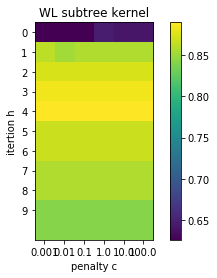

In [186]:
fig = plt.figure()
grid = np.asarray(perf).reshape(len(h_grid), len(c_grid))
plt.imshow(grid)
y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x = np.array([0, 1, 2, 3, 4, 5])
plt.xticks(x, c_grid)
plt.yticks(y, h_grid)
plt.xlabel('penalty c')
plt.ylabel('itertion h')
plt.title('WL subtree kernel')
plt.colorbar()
plt.show()
fig.savefig('graph_sub.png')

In [159]:
max(perf)
print(N)

188


In [187]:
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
h = 2
#compute Kernel matrix K, given H  
K = np.zeros([N, N])
for i in range(N): 
    for j in range(N):
        if (i <= j ):
            graph1 = X[i, ]
            graph2 = X[j, ]
            K[i, j] = wl_substree_kernel(graph1, graph2, tol, h)
        else: 
            K[i, j] = K[j, i]


In [188]:
perf_all_val = []
c = 0.1
for t in range(100):  
    random_state = int(t)
    np.random.seed(random_state)
    idx_perm = np.random.permutation(N)

    #Permute the data 
    y_perm = y[idx_perm]
    K_perm = K[:, idx_perm]
    K_perm = K_perm[idx_perm, :]

    #The paper use 10-folder CV (training: 90%; test: 10%)
    num_train = int (N * (9/10))
    num_test = N - num_train 

    #Split the kernel matrix 
    K_train = K_perm[0:num_train, 0:num_train] 
    K_test = K_perm[num_train:N, 0:num_train]
    y_train = y_perm[0:num_train]
    y_test = y_perm[num_train:N]

    #Fit classifier on training data 
    clf = svm.SVC(kernel = 'precomputed', C = c)
    clf.fit(K_train, y_train)

    #predict on test  
    y_pred_test = clf.predict(K_test)

    #accuracy on test set  
    acc = accuracy_score(y_test, y_pred_test);
    perf_all_val.append(acc) 

    #print("The performance on the test set is: %3f" % acc)

In [148]:
h = 4; c = 0.1


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [179]:
print(max(perf))
print("mean: ", np.mean(perf_all_val), np.std(perf_all_val)) 
#h = 4
#mean:  0.864210526316 0.0795346576836

0.889473684211
mean:  0.861578947368 0.08039204492


In [183]:
print(max(perf))
print("mean: ", np.mean(perf_all_val), np.std(perf_all_val)) 
#h = 3
#mean:  0.866842105263 0.0771568894887

0.889473684211
mean:  0.866842105263 0.0771568894887
